In [1]:
import numpy as np
import matplotlib.pyplot as plt

from hcipy import *
from poke.writing import read_serial_to_rayfront
from poke.interfaces import rayfront_to_hcipy_wavefront
from poke.materials import create_index_model
import poke.plotting as plot

from prysm._richdata import Slices
import numpy as np

# Load up GSMT Rayfronts

In [2]:
GSMT = ['TMT', 'ELT', 'GMT']
ORDER = 4
WHICH = 0 # 0 - 3
rfs = []

In [3]:
n_Al = create_index_model('Mathewson_Al')
n_Ag = create_index_model('Ag')
n_SiN = create_index_model('SiN')

In [4]:
exp = -5/3
wvl_new = 0.658
wvl_old = 1.6
opd_scale = (wvl_new**(exp)) / (wvl_old**exp)
print(opd_scale)

4.397003537998752


In [5]:
for tele in GSMT:
    pth = 'rayfronts/'+tele+'.msgpack'
    rf = read_serial_to_rayfront(pth)
    rf.wavelength = wvl_new

    # Bare Aluminum
    if tele == 'GMT':
        
        coat = n_Al(rf.wavelength)

    # Gemini Coating
    else:

        coat = [
            (2.4618, 5.5e-3), # H band
            (n_Ag(rf.wavelength))
        ]

    # re-do the surfaces
    if tele == 'ELT':
        s1 = {'surf': 1, 'coating':coat, 'mode': 'reflect'}
        s2 = {'surf': 2, 'coating':coat, 'mode': 'reflect'}
        s3 = {'surf': 3, 'coating':coat, 'mode': 'reflect'}
        s4 = {'surf': 5, 'coating':coat, 'mode': 'reflect'}
        s5 = {'surf': 9, 'coating':coat, 'mode': 'reflect'}
        surflist = [s1, s2, s3, s4, s5]

    else:
        s1 = {'surf': 1, 'coating':coat, 'mode': 'reflect'}
        s2 = {'surf': 2, 'coating':coat, 'mode': 'reflect'}
        s3 = {'surf': 5, 'coating':coat, 'mode': 'reflect'}
        surflist = [s1, s2, s3]


    rf.surfaces = surflist
    rf.compute_jones_pupil(aloc=np.array([0.,1.,0.]))
    rfs.append(rf)

In [6]:
from astropy.io import fits
gsmt_predir = 'gsmt_phs_screen/'
test = fits.getdata(gsmt_predir+f'gsmt_phs_screen_0{WHICH}.fits') * opd_scale
center = int(test.shape[0]/2)
print(center/2)
cut = 552
plt.imshow(test[center-cut:center+cut,center-cut:center+cut,2], cmap='RdBu')
plt.colorbar()
print(np.std(test[center-cut:center+cut,center-cut:center+cut,2]) / (2*np.pi) * 1600)

KeyboardInterrupt: 

## Load up PAOLA Data

In [7]:
for rf in rfs:
    print(rf.surfaces)

[{'surf': 1, 'coating': [(2.4618, 0.0055), (0.074+4.128557636887608j)], 'mode': 'reflect'}, {'surf': 2, 'coating': [(2.4618, 0.0055), (0.074+4.128557636887608j)], 'mode': 'reflect'}, {'surf': 5, 'coating': [(2.4618, 0.0055), (0.074+4.128557636887608j)], 'mode': 'reflect'}]
[{'surf': 1, 'coating': [(2.4618, 0.0055), (0.074+4.128557636887608j)], 'mode': 'reflect'}, {'surf': 2, 'coating': [(2.4618, 0.0055), (0.074+4.128557636887608j)], 'mode': 'reflect'}, {'surf': 3, 'coating': [(2.4618, 0.0055), (0.074+4.128557636887608j)], 'mode': 'reflect'}, {'surf': 5, 'coating': [(2.4618, 0.0055), (0.074+4.128557636887608j)], 'mode': 'reflect'}, {'surf': 9, 'coating': [(2.4618, 0.0055), (0.074+4.128557636887608j)], 'mode': 'reflect'}]
[{'surf': 1, 'coating': (1.6737557288712428+7.54443935904708j), 'mode': 'reflect'}, {'surf': 2, 'coating': (1.6737557288712428+7.54443935904708j), 'mode': 'reflect'}, {'surf': 5, 'coating': (1.6737557288712428+7.54443935904708j), 'mode': 'reflect'}]


# Set Up GSMT Apertures

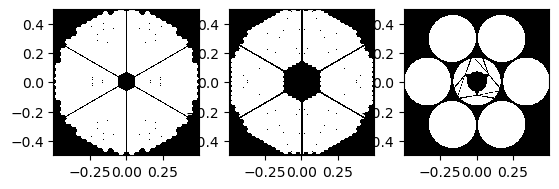

In [8]:
pupil_grid = make_pupil_grid(cut*2)
focal_grid = make_focal_grid(12,30)
prop = FraunhoferPropagator(pupil_grid, focal_grid)

tmtap = make_tmt_aperture(True)(pupil_grid)
eltap = make_elt_aperture(True)(pupil_grid)
gmtap = make_gmt_aperture(True)(pupil_grid)

aps = [tmtap, eltap, gmtap]
norms = []

plt.figure()
for i, ap in enumerate(aps):
    plt.subplot(1,3,i+1)
    imshow_field(ap, cmap='bone')

    wf_ref = Wavefront(ap)
    wf_ref = prop(wf_ref)
    norms.append(wf_ref.intensity.max())

# Convert Poke Rayfront to HCIPy Wavefront

In [9]:
wfs = []
for rf in rfs:
    wf = rayfront_to_hcipy_wavefront(rf, npix=cut*2, pupil_grid=pupil_grid)
    wfs.append(wf)

## Set up coronagraph

In [10]:
coros = []
wfs = []
for ap in aps:
    coro = PerfectCoronagraph(ap, order=ORDER)
    coros.append(coro)

    wf = rayfront_to_hcipy_wavefront(rf, npix=cut*2, pupil_grid=pupil_grid)
    wfs.append(wf)

## Simple PSF Simulation

In [11]:
gsmts_h = []
gsmts_v = []
gsmts_p = []
gsmts_m = []

for ap, coro, norm, wf in zip(aps, coros, norms, wfs):

    wfouts_h = []
    wfouts_v = []
    wfouts_p = []
    wfouts_m = []
    pbs_hv = LinearPolarizingBeamSplitter(0)
    pbs_pm = LinearPolarizingBeamSplitter(np.pi / 4)

    for i in range(100):

        frame = test[center-cut:center+cut,center-cut:center+cut,i]

        wfnew = wf

        phase_error = np.exp(1j*frame)
        wfnew.electric_field *= ap * phase_error.ravel()
        wfnew = coro.forward(wfnew)
        wfnew = prop(wfnew)
        wfh, wfv = pbs_hv.forward(wfnew)
        wfp, wfm = pbs_pm.forward(wfnew)
        wfouts_h.append(wfh)
        wfouts_v.append(wfv)
        wfouts_p.append(wfp)
        wfouts_m.append(wfm)

    # plt.figure()
    # imshow_field(np.log10(wfnew.I), vmin=-10, vmax=-4)
    # plt.colorbar()
    # plt.show()
    
    gsmts_h.append(wfouts_h)
    gsmts_v.append(wfouts_v)
    gsmts_p.append(wfouts_p)
    gsmts_m.append(wfouts_m)

In [12]:
gsmttotal_h = []
gsmttotal_v = []
gsmttotal_p = []
gsmttotal_m = []

for wfouts_h, wfouts_v, wfouts_p, wfouts_m, norm in zip(gsmts_h, gsmts_v, gsmts_p, gsmts_m, norms):

    for i, (wfh, wfv, wfp, wfm) in enumerate(zip(wfouts_h, wfouts_v, wfouts_p, wfouts_m)):

        if i == 0: 
            
            wftotal_h = wfh.intensity / norm 

            wftotal_v = wfv.intensity / norm

            wftotal_p = wfp.intensity / norm

            wftotal_m = wfm.intensity / norm

        else:

            wftotal_h += wfh.intensity / norm

            wftotal_v += wfv.intensity / norm

            wftotal_p += wfp.intensity / norm

            wftotal_m += wfm.intensity / norm

    gsmttotal_h.append(wftotal_h)
    gsmttotal_v.append(wftotal_v)
    gsmttotal_p.append(wftotal_p)
    gsmttotal_m.append(wftotal_m)

In [13]:
which = WHICH
wfdirectory = 'wfs/'
for gsmt, wftotal_h, wftotal_v, wftotal_p, wftotal_m in zip(GSMT, gsmttotal_h, gsmttotal_v, gsmttotal_p, gsmttotal_m):

    np.save(wfdirectory+gsmt+f'_100ms_exposure_0{which}_h_Rband.npy',wftotal_h)
    np.save(wfdirectory+gsmt+f'_100ms_exposure_0{which}_v_Rband.npy',wftotal_v)
    np.save(wfdirectory+gsmt+f'_100ms_exposure_0{which}_p_Rband.npy',wftotal_p)
    np.save(wfdirectory+gsmt+f'_100ms_exposure_0{which}_m_Rband.npy',wftotal_m)

In [27]:
# for i in range(0,10):
#     if i == 0:
#         wftotal_h = np.load(f'100ms_exposure_0{i}_h.npy')
#         wftotal_v = np.load(f'100ms_exposure_0{i}_v.npy')
#         wftotal_p = np.load(f'100ms_exposure_0{i}_p.npy')
#         wftotal_m = np.load(f'100ms_exposure_0{i}_m.npy')
#     else:
#         wftotal_h += np.load(f'100ms_exposure_0{i}_h.npy')
#         wftotal_v += np.load(f'100ms_exposure_0{i}_v.npy')
#         wftotal_p += np.load(f'100ms_exposure_0{i}_p.npy')
#         wftotal_m += np.load(f'100ms_exposure_0{i}_m.npy')

# wftotal_h /= i+1
# wftotal_v /= i+1
# wftotal_p /= i+1
# wftotal_m /= i+1

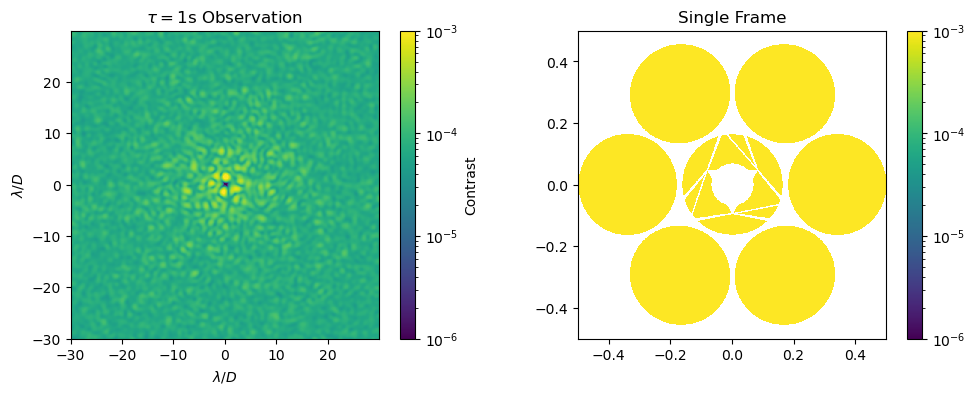

In [14]:
from matplotlib.colors import LogNorm

lognorm = LogNorm(vmin=1e-6, vmax=1e-3)

plt.figure(figsize=[12,4])
plt.subplot(121)
plt.title(r'$\tau=1$'+'s Observation')
imshow_field(wftotal_h, grid=focal_grid, norm=lognorm)
plt.xlabel(r'$\lambda / D$')
plt.ylabel(r'$\lambda / D$')
plt.colorbar(label='Contrast')
plt.subplot(122)
plt.title('Single Frame')
imshow_field((wf.I), norm=lognorm)
plt.colorbar()
plt.show()

Q near IWA =  0.00014147288914091572
U near IWA =  -1.2424080588314762e-05


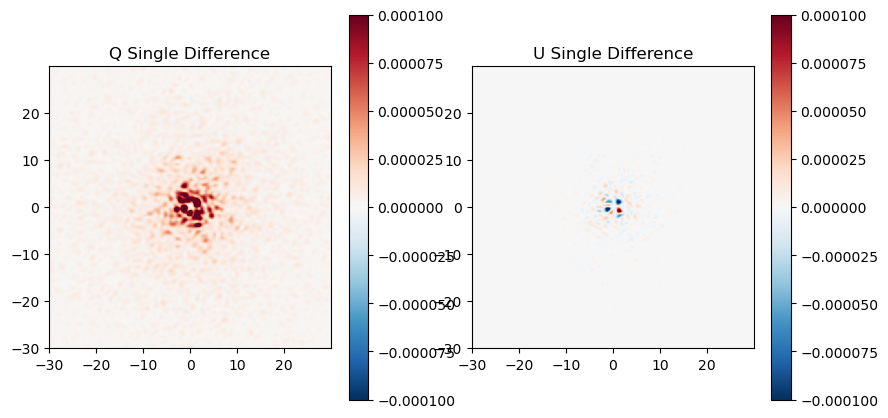

In [124]:
vlim = 1e-4
u = np.linspace(-30,30,720)
u, v = np.meshgrid(u, u)
rho = np.sqrt(u**2 + v**2)
rho = rho.ravel()
focal_mask = np.zeros_like(wftotal_h)
focal_mask[rho > 1] = 1
focal_mask[rho > 2] = 0
q = wftotal_h - wftotal_v
u = wftotal_p - wftotal_m
print('Q near IWA = ', np.mean(q[focal_mask==1]))
print('U near IWA = ', np.mean(u[focal_mask==1]))
plt.figure(figsize=[10, 5])
plt.subplot(121)
plt.title('Q Single Difference')
imshow_field(q, grid=focal_grid, cmap='RdBu_r', vmin=-vlim, vmax=vlim)
plt.colorbar()
plt.subplot(122)
plt.title('U Single Difference')
imshow_field(u, grid=focal_grid, cmap='RdBu_r', vmin=-vlim, vmax=vlim)
plt.colorbar()
plt.show()

In [44]:
x = np.linspace(-30,30,wftotal_h.reshape([720,720]).shape[0])
y = np.copy(x)

I = Slices(wftotal_h.reshape([720,720]) + wftotal_v.reshape([720,720]), x, y)
std_i = I.azstd

Q = Slices(wftotal_h.reshape([720,720]) - wftotal_v.reshape([720,720]), x, y)
std_q = Q.azstd
U = Slices(wftotal_p.reshape([720,720]) - wftotal_m.reshape([720,720]), x, y)
std_u = U.azstd

In [52]:
# np.save('std_I_1s_1mmtint.npy',std_i[1])
# np.save('std_Q_1s_1mmtint.npy',std_q[1])
# np.save('std_U_1s_1mmtint.npy',std_u[1])

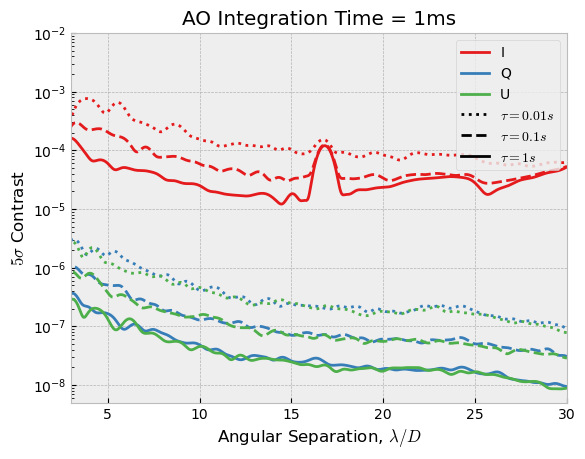

In [54]:
std_i_1s = np.load('std_I_1s_1mmtint.npy')
std_q_1s = np.load('std_Q_1s_1mmtint.npy')
std_u_1s = np.load('std_U_1s_1mmtint.npy')

std_i_01s = np.load('std_I_0.1s_1mmtint.npy')
std_q_01s = np.load('std_Q_0.1s_1mmtint.npy')
std_u_01s = np.load('std_U_0.1s_1mmtint.npy')

std_i_001s = np.load('std_I_0.01s_1mmtint.npy')
std_q_001s = np.load('std_Q_0.01s_1mmtint.npy')
std_u_001s = np.load('std_U_0.01s_1mmtint.npy')

plt.style.use('bmh')
n = 9
color = plt.cm.Set1(np.linspace(0,1,n))
xpro = std_u[0]#np.linspace(0,30,len(std_i_01s))

plt.title('AO Integration Time = 1ms')
plt.plot(xpro,std_i_1s * 5, label='I', color=color[0], linestyle='solid')
plt.plot(xpro,std_q_1s * 5, label='Q', color=color[1], linestyle='solid')
plt.plot(xpro,std_u_1s * 5, label='U', color=color[2], linestyle='solid')
plt.plot(xpro,std_i_01s * 5, color=color[0], linestyle='dashed')
plt.plot(xpro,std_q_01s * 5, color=color[1], linestyle='dashed')
plt.plot(xpro,std_u_01s * 5, color=color[2], linestyle='dashed')
plt.plot(xpro,std_i_001s * 5, color=color[0], linestyle='dotted')
plt.plot(xpro,std_q_001s * 5, color=color[1], linestyle='dotted')
plt.plot(xpro,std_u_001s * 5, color=color[2], linestyle='dotted')
plt.plot(xpro,np.zeros_like(std_i_01s), color='k', linestyle='dotted', label=r'$\tau=0.01s$')
plt.plot(xpro,np.zeros_like(std_i_01s), color='k', linestyle='dashed', label=r'$\tau=0.1s$')
plt.plot(xpro,np.zeros_like(std_i_01s), color='k', linestyle='solid', label=r'$\tau=1s$')
plt.yscale('log')
plt.ylim(5e-9,1e-2)
plt.xlim(3,30)
plt.ylabel(r'$5\sigma$'+' Contrast')
plt.xlabel('Angular Separation, '+r'$\lambda / D$')
plt.legend()

In [43]:
0.25 / 206265 * (8.1 / 1.65e-6)

5.9499804972861465